In [591]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('qdrops.csv', parse_dates=True)

df = df.sort_values(by='drop_id')
# df = df.set_index('drop_id')

# df['hour'] = pd.to_datetime(df.date).dt.hour
# df['hour_utc'] = pd.to_datetime(df.date).dt.tz_convert("UTC").dt.hour
# df['time_utc'] = pd.to_datetime(df.date).dt.tz_convert("UTC").dt.time
# df['weekday'] = pd.to_datetime(df.date).dt.dayofweek

df['date'] = pd.to_datetime(df.date)

# # Update: Use fractional hours
# df['hour_utc'] += df.date.dt.minute / 60
# df['hour'] += df.date.dt.minute / 60

# df['minutes_since_last_drop'] = pd.to_datetime(df.date).diff().dt.total_seconds() / 60
# df['minutes_since_last_drop'] = df.minutes_since_last_drop.replace(0, 0.05)
# df['minutes_since_last_drop_avg'] = df.minutes_since_last_drop.rolling(window=5).mean()
# df['post_length_chars'] = df.body_text.str.len()


# Set color palette and default theme
sns.set_palette("tab10", 8)
sns.set()

def print_drops(drops) -> None:
    for i, drop in drops.iterrows():
        print('[{}] Drop #{}: \n\n {}\n'.format(drop.date, drop.drop_id, drop.body_text), '\n')
    
def search_drops(search_string: str, regex=False) -> None:
    results = df[df.body_text.str.contains(search_string, regex=regex)]

    print('Found {} matches. \n'.format(len(results)))
    print_drops(results)


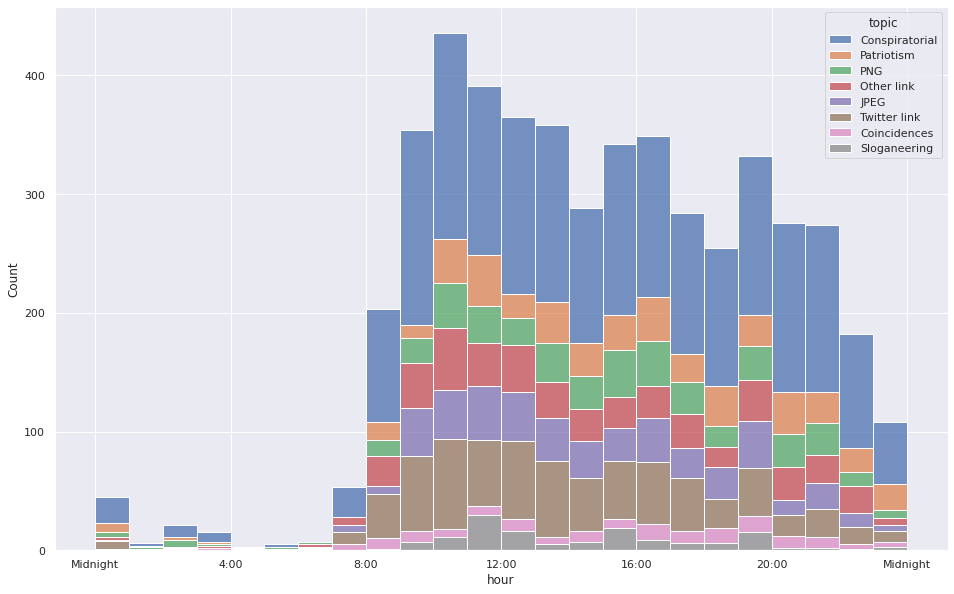

In [431]:
fig = plt.gcf()

fig.set_size_inches(16, 10)

sns.histplot(df, x='hour', binwidth=1, hue='topic', multiple='stack')
p = plt.xticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

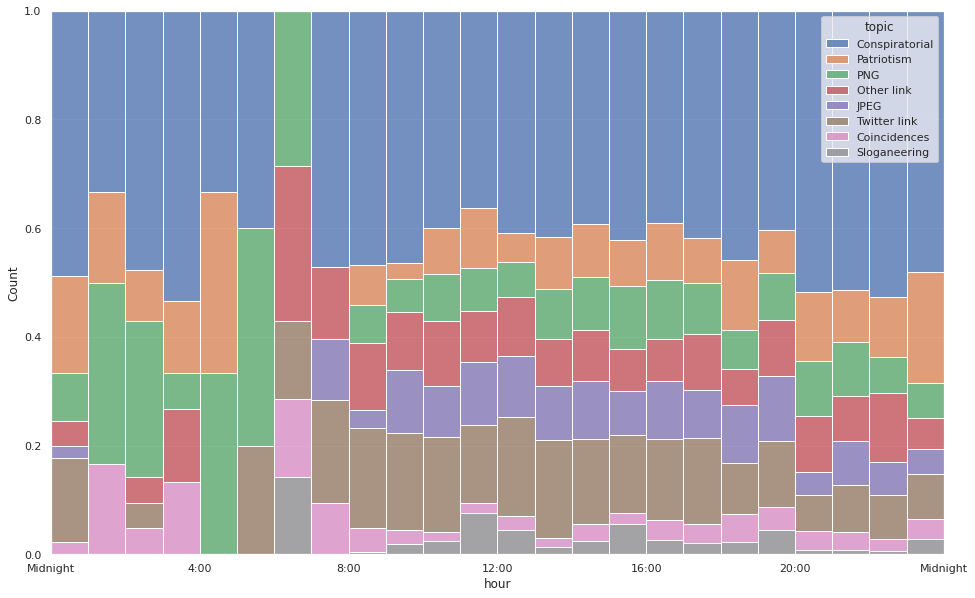

In [432]:
fig = plt.gcf()

fig.set_size_inches(16, 10)

sns.histplot(df, x='hour', binwidth=1, hue='topic', multiple='fill')
p = plt.xticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

In [433]:
posts_within_1_hr = df[df.minutes_since_last_drop <= 60]
posts_within_6_hrs = df[df.minutes_since_last_drop <= 360]
posts_within_30_mins = df[df.minutes_since_last_drop <= 30]

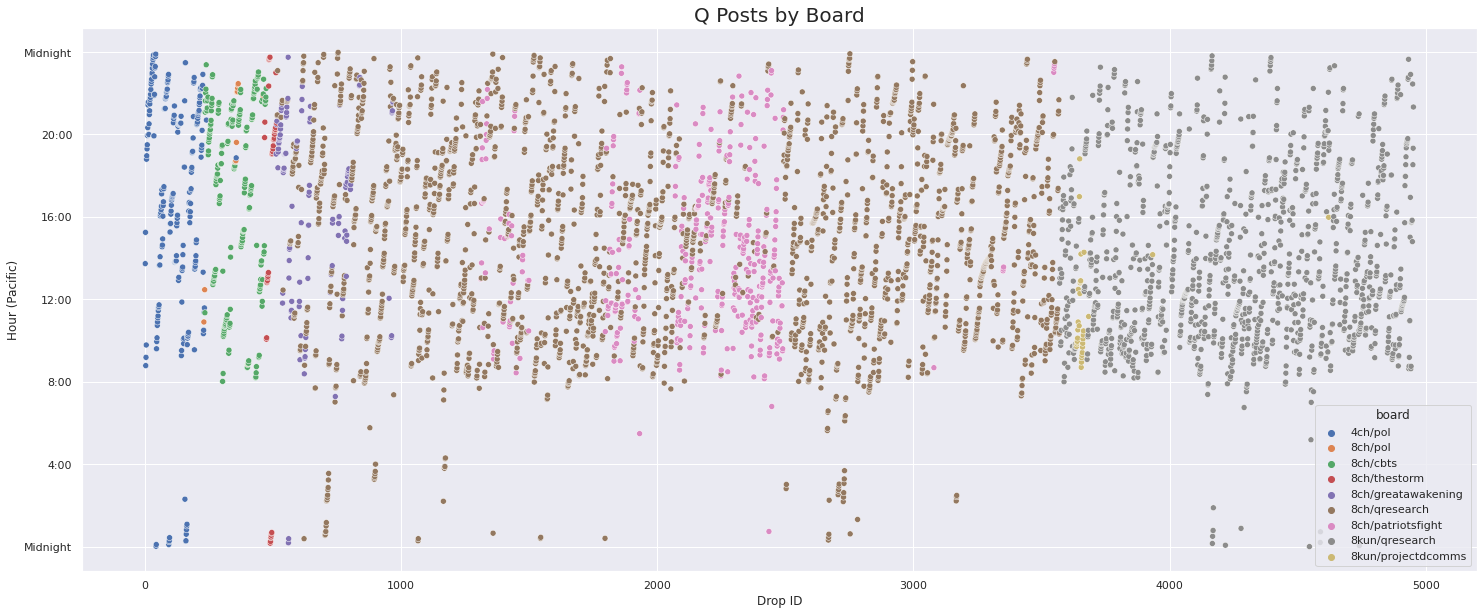

In [434]:
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(25, 10)

sns.scatterplot(data=df, x='drop_id', y='hour', hue='board').set_title('Q Posts by Board', size=20)
p = plt.xlabel("Drop ID", size=12)
p = plt.ylabel("Hour (Pacific)", size=12)
p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

In [435]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = tfidf_vect.fit_transform(df.body_text.values.astype('U'))

from sklearn.decomposition import NMF

nmf = NMF(n_components=8, random_state=42)
nmf.fit(doc_term_matrix)

for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:][::-1]])
    print('\n')

/home/robert/.local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Top 10 words for topic #0:
['status', 'twitter', 'com', 'https', 'realdonaldtrump', 'vip', 'mobile', 'patriot', 'love', 'cbs_herridge']


Top 10 words for topic #1:
['jpg', 'large', '220px', 'pain', 'anons', 'remember', 'remembering', 'enemy', 'reconcile', 'unknown']


Top 10 words for topic #2:
['png', 'clipboardimage', 'delta', 'screen', 'shot', 'coincidence', 'anon', 'realdonaldtrump', 'united', 'large']


Top 10 words for topic #3:
['youtube', 'watch', 'www', 'https', 'com', 'feature', 'g2qixxafxcq', 'youtu', 'politics', 'html']


Top 10 words for topic #4:
['news', 'potus', 'think', 'people', 'did', 'fake', 'public', 'control', 'fbi', 'www']


Top 10 words for topic #5:
['jpeg', 'coincidence', 'coincidences', 'believe', 'ready', 'patriots', 'game', 'image0', 'news', 'hear']


Top 10 words for topic #6:
['wwg1wga', 'stand', 'united', 'status', 'win', 'wrwy', 'qthewakeup', 'stop', 'twitter', 'great']


Top 10 words for topic #7:
['god', 'patriots', 'bless', 'country', 'stand', 'patr

## My best guess at labeling the above topics:

- 0: Twitter link
- 1: JPEG
- 2: PNG
- 3: Youtube video
- 4: Conspiratorial
- 5: Coincidences
- 6: Sloganeering
- 7: Patriotism


In [7]:
topic_values = nmf.transform(doc_term_matrix)
topics = pd.DataFrame(topic_values)
topics.columns = ['Twitter link', 'JPEG', 'PNG', 'Other link', 'Conspiratorial', 'Coincidences', 'Sloganeering', 'Patriotism']
topics['drop_id'] = topics.index + 1
topics = topics.set_index('drop_id')
topics=((topics-topics.min())/(topics.max()-topics.min()))

In [29]:
df['topic'] = topics.columns[topic_values.argmax(axis=1)]
topic_twitter = df[df.topic == 'Twitter link']
topic_jpeg = df[df.topic == 'JPEG']
topic_png = df[df.topic == 'PNG']
topic_other = df[df.topic == 'Other link']
topic_conspiratorial = df[df.topic == 'Conspiratorial']
topic_coincidences = df[df.topic == 'Coincidences']
topic_sloganeering = df[df.topic == 'Sloganeering']
topic_patriotism = df[df.topic == 'Patriotism']

/home/robert/.local/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


NameError: name 'posts_under_250_chars' is not defined

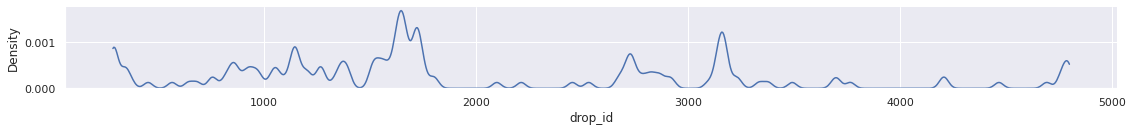

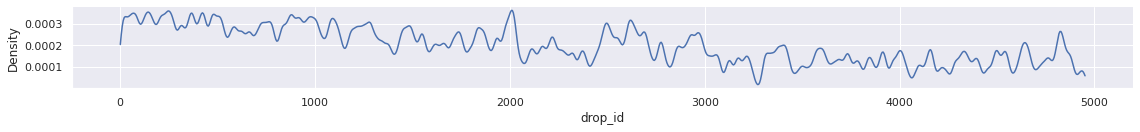

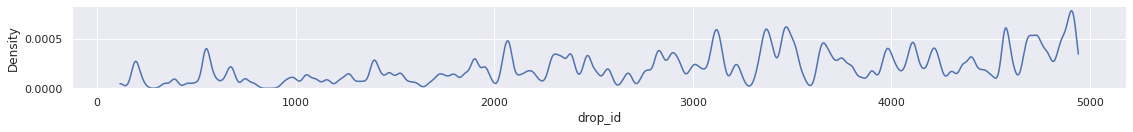

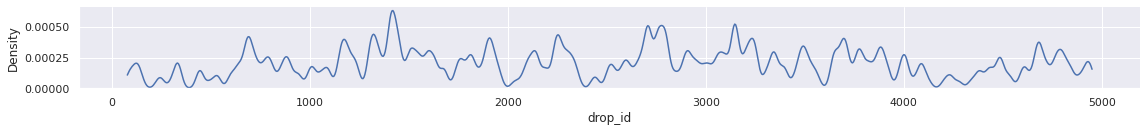

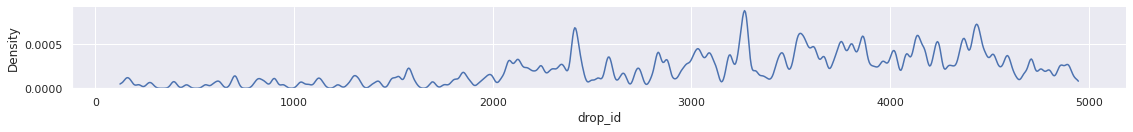

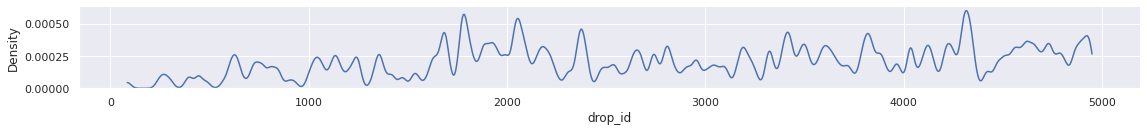

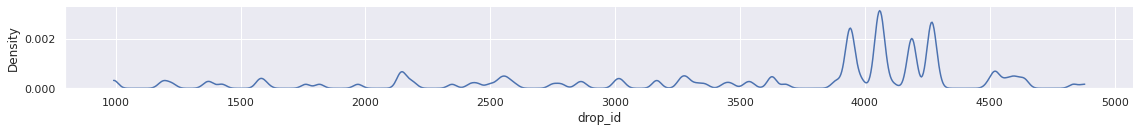

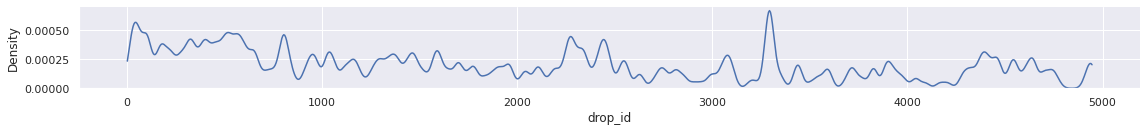

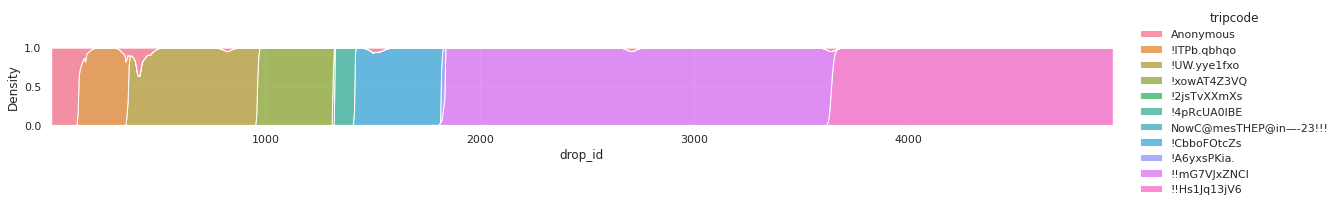

In [380]:
# rolling_avg_topics = topics.rolling(window=150).mean()

sns.displot(topic_coincidences, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_conspiratorial, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_jpeg, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_png, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_twitter, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_other, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_sloganeering, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(topic_patriotism, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)

sns.displot(df, x='drop_id', hue='tripcode', multiple='fill', kind='kde', height=2, aspect=8, bw_adjust=0.1, gridsize=1000, cut=0, legend=True)
sns.displot(posts_under_250_chars, x='drop_id', hue='topic', cumulative=False, kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.05, gridsize=1000, cut=0, legend=True)

posts_150_to_650 = df[149:650]
sns.displot(posts_150_to_650, x='drop_id', hue='tripcode', multiple='fill', kind='kde', height=2, aspect=8, bw_adjust=0.1, gridsize=1000, cut=0, legend=False)
sns.displot(posts_150_to_650, x='drop_id', hue='topic', kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.1, gridsize=1000, cut=0, legend=False)


posts_1750_to_1900 = df[1749:1900]
topic_conspiratorial = posts_1750_to_1900[posts_1750_to_1900.topic == 'Conspiratorial']
sns.displot(posts_1750_to_1900, x='drop_id', hue='tripcode', multiple='fill', kind='kde', height=2, aspect=8, bw_adjust=0.1, gridsize=1000, cut=0, legend=True)
sns.displot(topic_conspiratorial, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(posts_1750_to_1900, x='drop_id', hue='topic', kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.1, gridsize=1000, cut=0, legend=True)

posts_3500_to_3800 = df[3499:3800]
topic_conspiratorial = posts_3500_to_3800[posts_3500_to_3800.topic == 'Conspiratorial']
sns.displot(posts_3500_to_3800, x='drop_id', hue='tripcode', multiple='fill', kind='kde', height=2, aspect=8, bw_adjust=0.1, gridsize=1000, cut=0, legend=False)
sns.displot(topic_conspiratorial, x='drop_id', hue='topic', kind='kde', height=2, aspect=8, bw_adjust=0.05, gridsize=1000, cut=0, legend=False)
sns.displot(posts_3500_to_3800, x='drop_id', hue='topic', kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.1, gridsize=1000, cut=0, legend=False)

In [11]:
tripcodes = df.tripcode.unique()
total_drops = len(df)

top_8_Qs = []

for tripcode in tripcodes:
    if (len(df[df.tripcode == tripcode]) / total_drops * 100) > 1:
        top_8_Qs.append(tripcode)

for tripcode in top_8_Qs:
    all_posts_by_tripcode = df[df.tripcode == tripcode]
    uppercase_posts = all_posts_by_tripcode[all_posts_by_tripcode.is_uppercase]
    pct_uppercase = len(uppercase_posts) / len(all_posts_by_tripcode)
    print('{0}\t{1:.2%} uppercase'.format(tripcode, pct_uppercase))

Anonymous	1.23% uppercase
!ITPb.qbhqo	2.68% uppercase
!UW.yye1fxo	6.17% uppercase
!xowAT4Z3VQ	3.13% uppercase
!4pRcUA0lBE	1.06% uppercase
!CbboFOtcZs	1.00% uppercase
!!mG7VJxZNCI	3.06% uppercase
!!Hs1Jq13jV6	1.90% uppercase


Text(0, 0.5, 'Board')

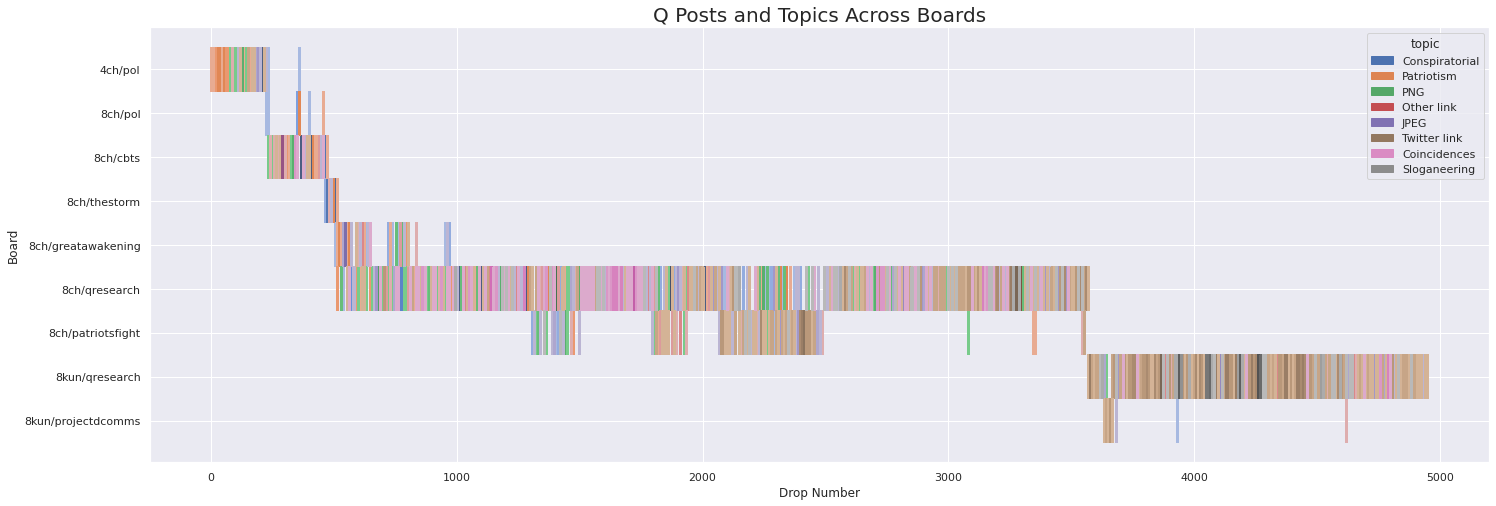

In [436]:
fig = plt.gcf()
fig.set_size_inches(24, 8)
sns.histplot(data=df, x='drop_id', y='board', hue='topic', bins=600).set_title('Q Posts and Topics Across Boards', size=20)

fig.set_size_inches(24, 8)
plt.xlabel("Drop Number", size=12)
plt.ylabel("Board", size=12)



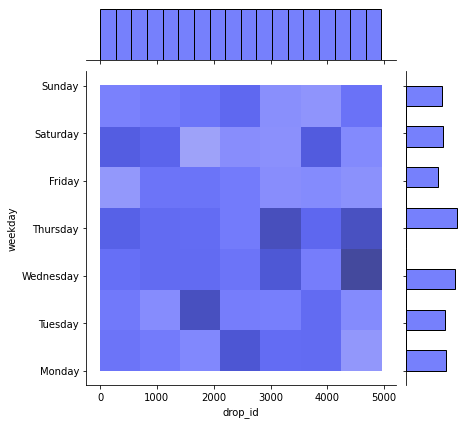

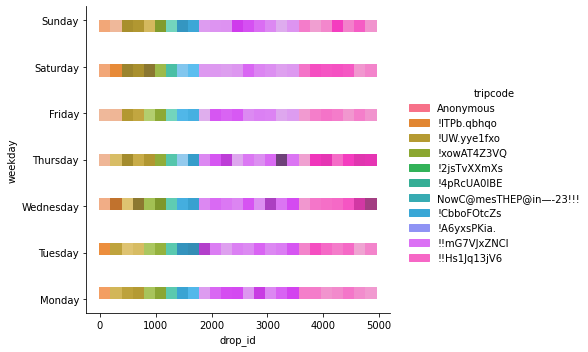

In [14]:
sns.jointplot(data=df, x='drop_id', y='weekday', bins=7, kind='hist')
p = plt.yticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))

sns.displot(data=df, x='drop_id', y='weekday', hue='tripcode', bins=25)
p = plt.yticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))

In [15]:
q_replies = df[df.is_reply]
q_replies = pd.DataFrame(q_replies)
q_replies

drop_id                       date      tripcode           board  \
0           1  2017-10-28 13:44:28-07:00     Anonymous         4ch/pol   
27         28  2017-10-31 22:59:01-07:00     Anonymous         4ch/pol   
50         51  2017-11-02 11:12:06-07:00     Anonymous         4ch/pol   
57         58  2017-11-02 13:40:27-07:00     Anonymous         4ch/pol   
65         66  2017-11-02 17:19:28-07:00     Anonymous         4ch/pol   
...       ...                        ...           ...             ...   
4876     4877  2020-10-15 14:33:19-07:00  !!Hs1Jq13jV6  8kun/qresearch   
4877     4878  2020-10-15 14:54:41-07:00  !!Hs1Jq13jV6  8kun/qresearch   
4878     4879  2020-10-15 14:56:51-07:00  !!Hs1Jq13jV6  8kun/qresearch   
4909     4910  2020-10-21 11:47:34-07:00  !!Hs1Jq13jV6  8kun/qresearch   
4939     4940  2020-10-22 16:57:32-07:00  !!Hs1Jq13jV6  8kun/qresearch   

          thread      time       hour   hour_utc  time_utc  \
0            NaN  13:44:28  13.733333  20.733333  20:44:28   
27           NaN  22:59:01  22.983333   5.983333  05:59:01   
50           NaN  11:12:06  11.200000  18.200000  18:12:06   
57           NaN  13:40:27  13.666667  20.666667  20:40:27   
65           NaN  17:19:28  17.316667   0.316667  00:19:28   
...          ...       ...        ...        ...       ...   
4876  11090367.0  14:33:19  14.550000  21.550000  21:33:19   
4877  11090814.0  14:54:41  14.900000  21.900000  21:54:41   
4878  11090880.0  14:56:51  14.933333  21.933333  21:56:51   
4909  11192736.0  11:47:34  11.783333  18.783333  18:47:34   
4939  11223312.0  16:57:32  16.950000  23.950000  23:57:32   

      minutes_since_last_drop  ...  \
0                         NaN  ...   
27                   2.916667  ...   
50                   5.133333  ...   
57                   0.816667  ...   
65                  12.166667  ...   
...                       ...  ...   
4876                 0.616667  ...   
4877                21.366667  ...   
4878                 2.166667  ...   
4909                 3.650000  ...   
4939               116.116667  ...   

                                              body_text  Unnamed: 17  \
0      >>147005381 >>146981635 Hillary Clinton will ...          NaN   
27     >>147450119 Spy.png >>147441102 >What must be...          NaN   
50     >>147642589 one-nation-under-god-t-shirt_desi...          NaN   
57     >>147661217 http://thehill.com/blogs/pundits-...          NaN   
65     >>147688276 >>147687684 Let's be clear - you'...          NaN   
...                                                 ...          ...   
4876                            >>11090349 Capture.jpg           NaN   
4877   >>11090593 twitter_over_capacity.jpg Q YOU BR...          NaN   
4878   >>11090775 ClipboardImage.png https://twitter...          NaN   
4909   >>11192597 >>11192505 So many people refuse s...          NaN   
4939   >>11223081 Screen_Shot_2020_10_22_at_6_48_37_...          NaN   

      Unnamed: 18  Unnamed: 19 Unnamed: 20  Unnamed: 21 Unnamed: 22  \
0             NaN          NaN         NaN          NaN         NaN   
27            NaN          NaN         NaN          NaN         NaN   
50            NaN          NaN         NaN          NaN         NaN   
57            NaN          NaN         NaN          NaN         NaN   
65            NaN          NaN         NaN          NaN         NaN   
...           ...          ...         ...          ...         ...   
4876          NaN          NaN         NaN          NaN         NaN   
4877          NaN          NaN         NaN          NaN         NaN   
4878          NaN          NaN         NaN          NaN         NaN   
4909          NaN          NaN         NaN          NaN         NaN   
4939          NaN          NaN         NaN          NaN         NaN   

     Unnamed: 23 Unnamed: 24 Unnamed: 25  
0            NaN         NaN         NaN  
27           NaN         NaN         NaN  
50           NaN         NaN         NaN  
57           NaN         

In [16]:
from datetime import datetime
import pytz

tz = pytz.timezone('America/Los_Angeles')

daylight_savings_1 = df[df.date >= datetime.fromisoformat('2019-02-10').astimezone(tz)]
daylight_savings_1 = daylight_savings_1[daylight_savings_1.date <= datetime.fromisoformat('2019-04-10').astimezone(tz)]

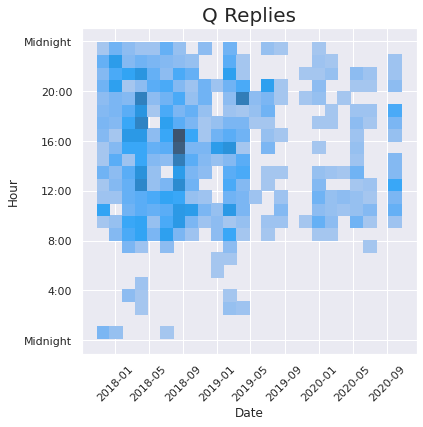

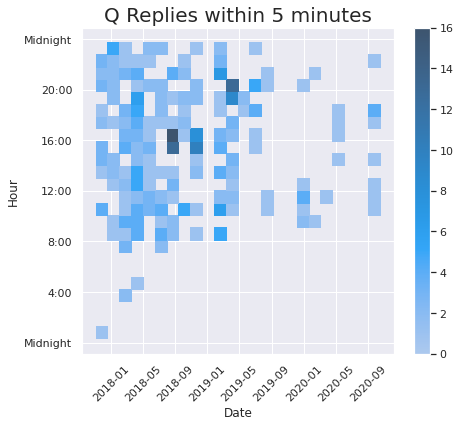

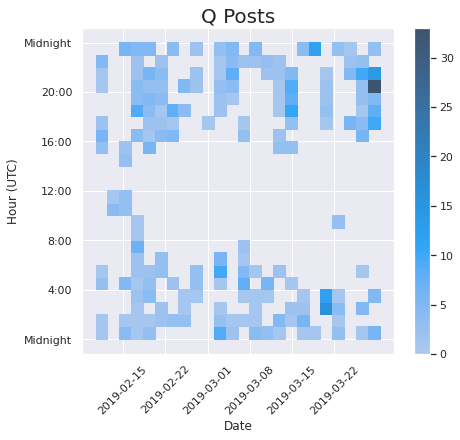

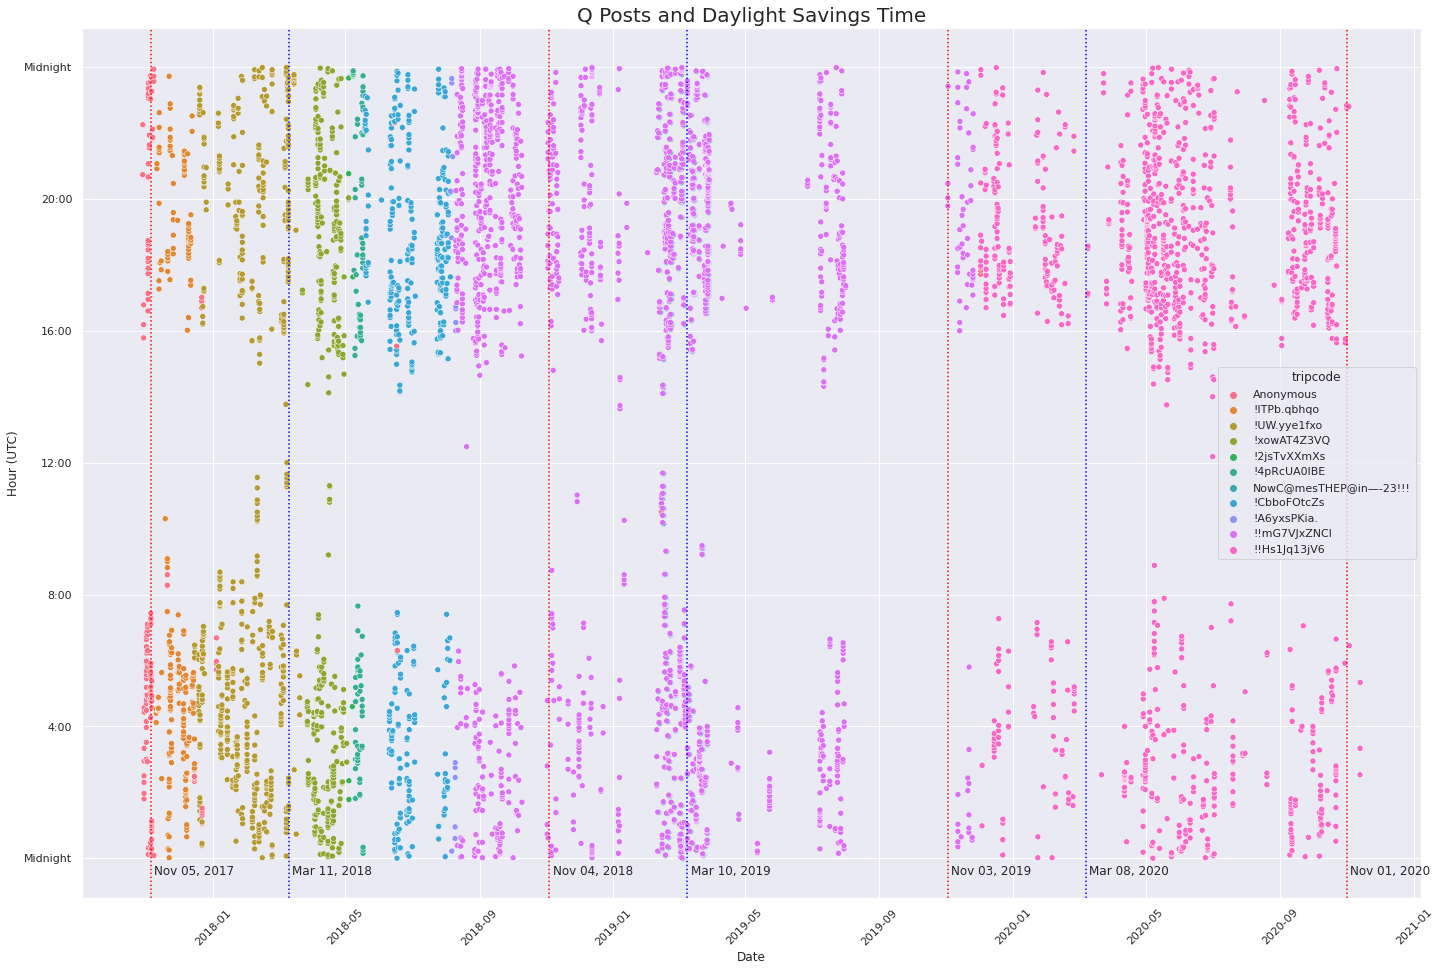

In [372]:
plt.figure(figsize=(6,6))
sns.histplot(data=q_replies, x='date', y='hour', bins=24).set_title('Q Replies', size=20)
plt.xticks(rotation=45)
plt.xlabel("Date", size=12)
plt.ylabel("Hour", size=12)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))
plt.show()

q_replies['minutes_since_last_reply'] = pd.to_datetime(q_replies.date, utc=True).diff().dt.total_seconds() / 60
q_replies_with_30_minutes = q_replies[q_replies['minutes_since_last_reply'] <= 5]

plt.figure(figsize=(7,6))
sns.histplot(data=q_replies_with_30_minutes, x='date', y='hour', bins=24, cbar=True).set_title('Q Replies within 5 minutes', size=20)
plt.xticks(rotation=45)
plt.xlabel("Date", size=12)
plt.ylabel("Hour", size=12)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))
plt.show()

plt.figure(figsize=(7,6))
sns.histplot(data=daylight_savings_1, x='date', y='hour_utc', bins=24, cbar=True).set_title('Q Posts', size=20)
plt.xticks(rotation=45)
plt.xlabel("Date", size=12)
plt.ylabel("Hour (UTC)", size=12)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))
plt.show()

fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(12, 12)
plt.xticks(rotation=45)

sns.scatterplot(data=daylight_savings_1, x='date', y='hour_utc').set_title('Q Posts, 2/10 2019 through 4/10 2019', size=20)
plt.xlabel("Date", size=12)
plt.ylabel("Hour (UTC)", size=12)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(24, 16)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

sns.scatterplot(data=df, x='date', y='hour_utc', hue='tripcode').set_title('Q Posts and Daylight Savings Time', size=20)
plt.xlabel("Date", size=12)
plt.ylabel("Hour (UTC)", size=12)
plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

dst_dates = [
    datetime.fromisoformat('2017-11-05'),
    datetime.fromisoformat('2018-03-11'),
    datetime.fromisoformat('2018-11-04'),
    datetime.fromisoformat('2019-03-10'),
    datetime.fromisoformat('2019-11-03'),
    datetime.fromisoformat('2020-03-08'),
    datetime.fromisoformat('2020-11-01')
]

color = 'red'

from datetime import timedelta

for dst in dst_dates:
    plt.axvline(x=dst, ls=':', color=color)
    plt.text(x = dst + timedelta(days=3), y = -0.5, s = dst.strftime("%b %d, %Y"))
    if color == 'red':
        color = 'blue'
    else:
        color = 'red'
    

In [850]:
# First drop on 8ch: #230
print(df[df.board.str.startswith('8ch')].iloc[0])

# First drop on 8kun: #3571
print(df[df.board.str.startswith('8kun')].iloc[0])

# First drop w/ tripcode !Cbb... #1417
print(df[df.tripcode.str.startswith('!Cbb')].iloc[0])

# First drop w/ tripcode !xow... #962
print(df[df.tripcode.str.startswith('!xow')].iloc[0])

# First drop w/ tripcode !2js... #1312
print(df[df.tripcode.str.startswith('!2js')].iloc[0])

# First drop w/ tripcode !2js... #1312
print(df[df.topic == 'Sloganeering'].iloc[0])

drop_id                                                                        230
date                                                     2017-11-25 10:54:45-08:00
tripcode                                                               !ITPb.qbhqo
board                                                                      8ch/pol
thread                                                                         NaN
time                                                                      10:54:45
hour                                                                     10.900000
hour_utc                                                                 18.900000
time_utc                                                                  18:54:45
minutes_since_last_drop                                                  23.966667
minutes_since_last_drop_avg                                             438.313333
post_length_chars                                                               67
week

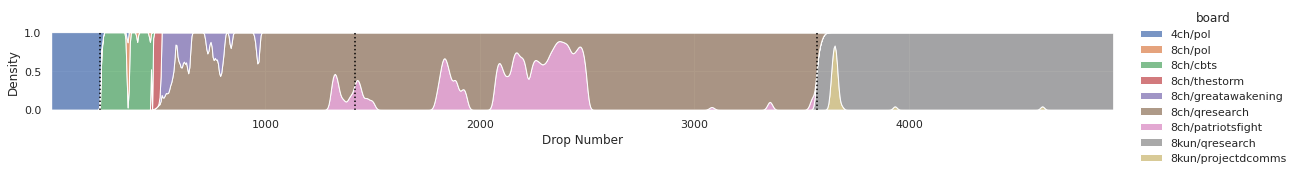

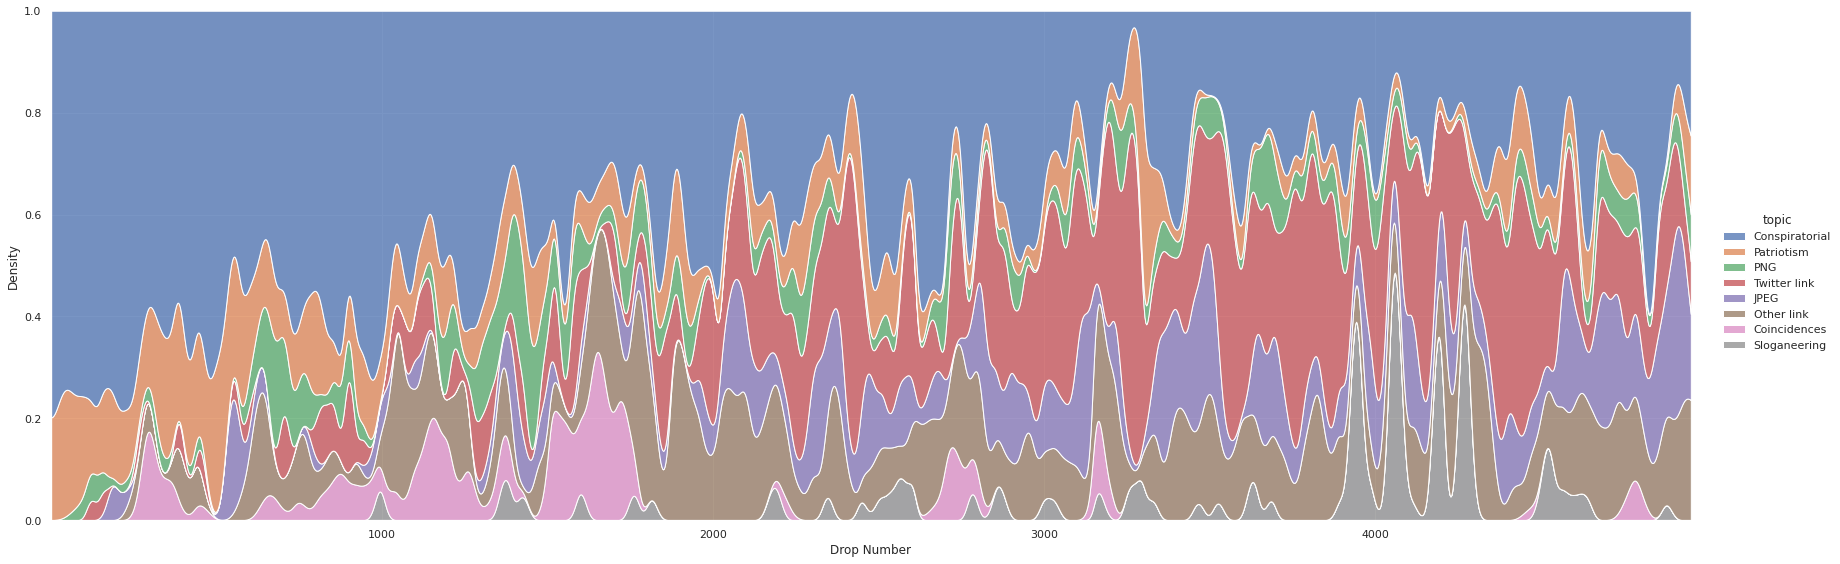

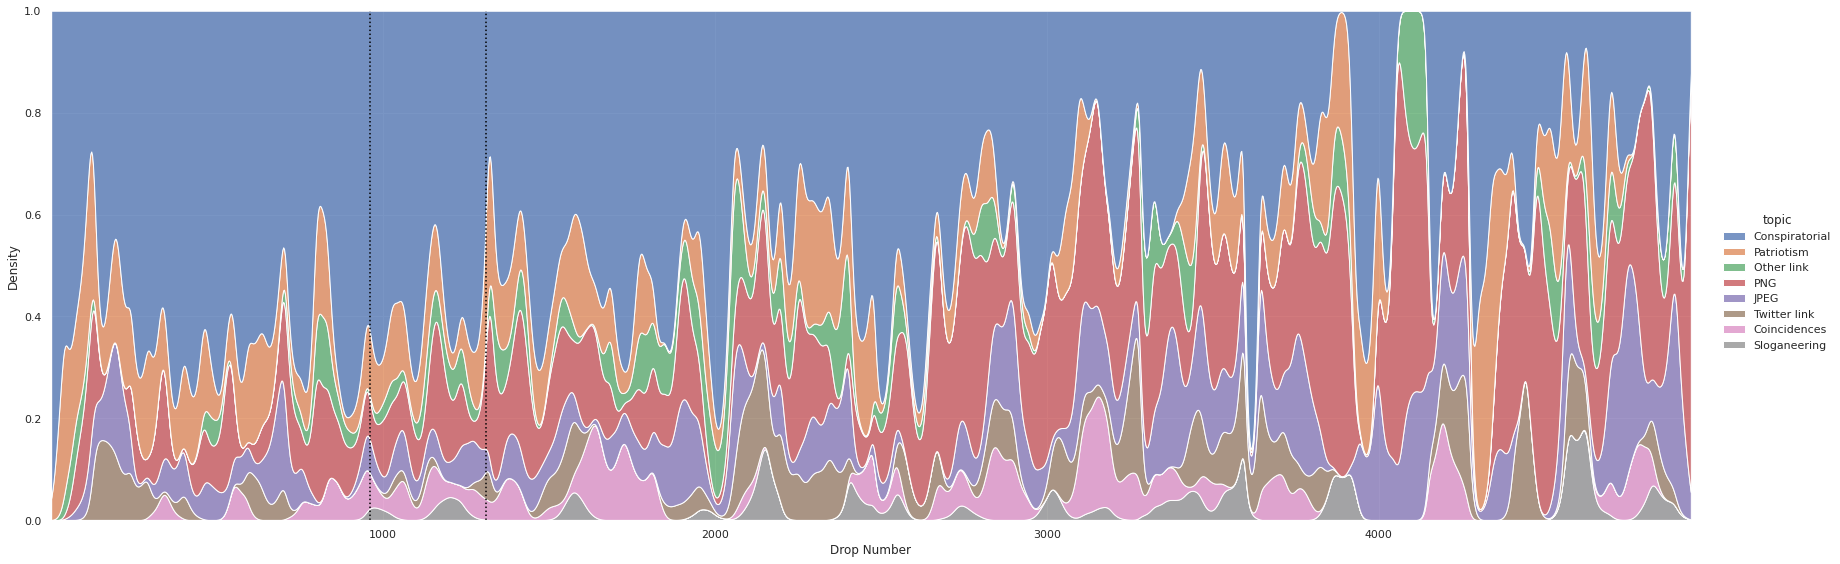

In [836]:
sns.displot(df, x='drop_id', hue='board', multiple='fill', kind='kde', height=2, aspect=8, bw_adjust=0.1, gridsize=1000, cut=0, legend=True)
plt.xlabel("Drop Number", size=12)

plt.axvline(x=230, ls=':', color='black')
plt.axvline(x=1417, ls=':', color='black')
plt.axvline(x=3571, ls=':', color='black')

non_replies = df[df.is_reply == False]

sns.displot(non_replies, x='drop_id', hue='topic', cumulative=False, kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.05, gridsize=2000, cut=0, legend=True)
plt.xlabel("Drop Number", size=12)

sns.displot(q_replies, x='drop_id', hue='topic', cumulative=False, kind='kde', multiple='fill', height=8, aspect=3, bw_adjust=0.05, gridsize=2000, cut=0, legend=True)
plt.xlabel("Drop Number", size=12)

plt.axvline(x=962, ls=':', color='black')
plt.axvline(x=1312, ls=':', color='black')

<ipython-input-20-9680a6600840>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  posts_3250_to_3750 = df[df.drop_id >= 3250][df.drop_id <= 3750]


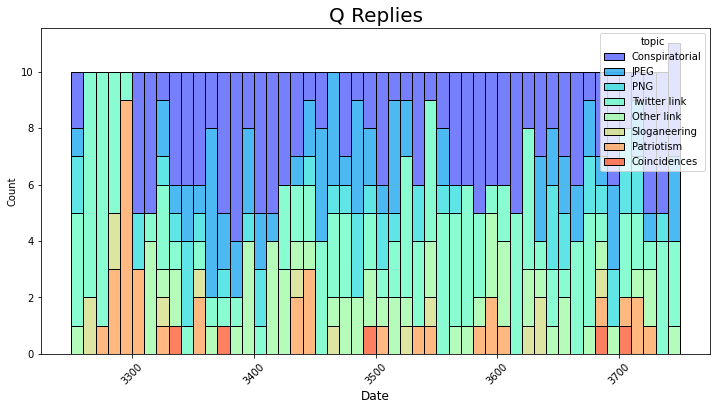

In [20]:
plt.figure(figsize=(12,6))
posts_3250_to_3750 = df[df.drop_id >= 3250][df.drop_id <= 3750]
sns.histplot(data=posts_3250_to_3750, x='drop_id', hue='topic', multiple='stack', bins=50).set_title('Q Replies', size=20)
plt.xticks(rotation=45)
plt.xlabel("Date", size=12)
plt.show()

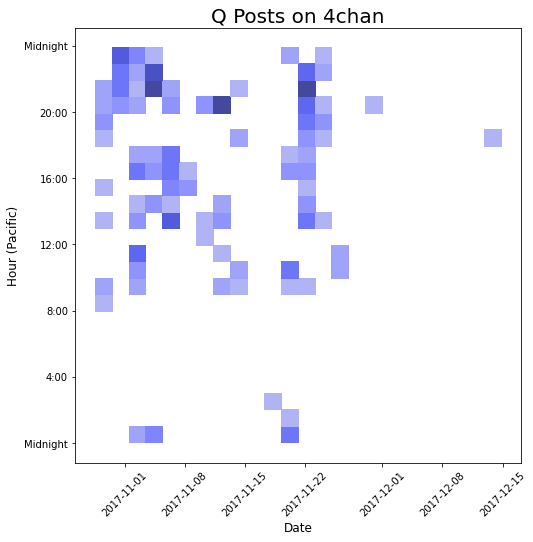

In [244]:
fch_posts = df[df.board.str.startswith('4ch')]

fig = plt.gcf()
fig.set_size_inches(8, 8)
p = plt.xticks(rotation=45)

sns.histplot(data=fch_posts, x='date', y='hour', bins=24).set_title('Q Posts on 4chan', size=20)
p = plt.xlabel("Date", size=12)
p = plt.ylabel("Hour (Pacific)", size=12)
p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

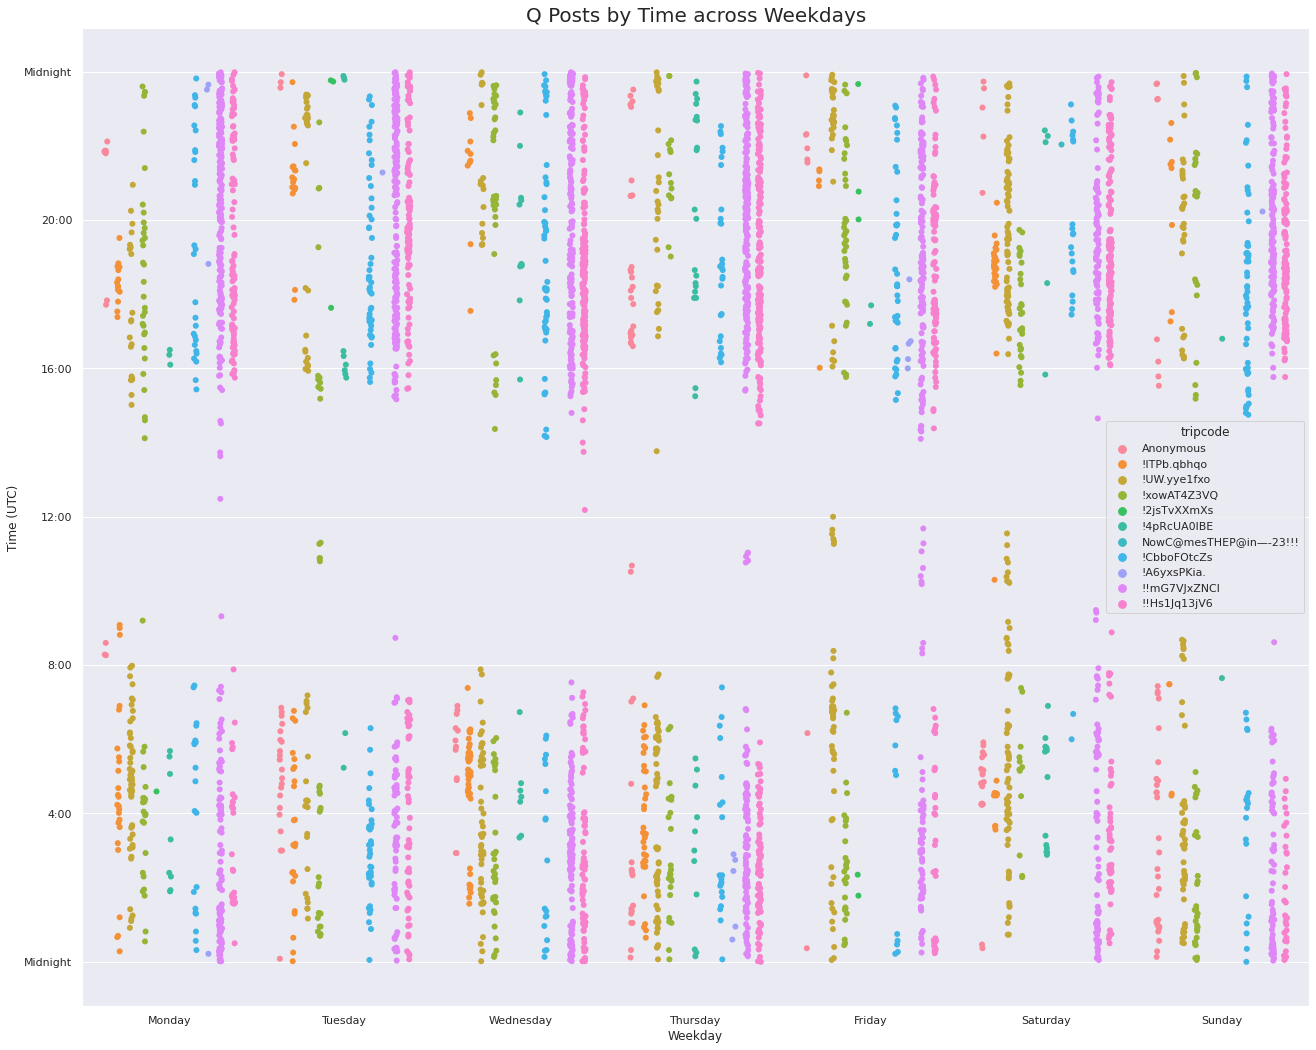

In [370]:
# weekdays = df.replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
fig = plt.gcf()
fig.set_size_inches(22, 18)

sns.set_palette('tab10')
sns.stripplot(x="weekday", y="hour_utc", data=df, hue="tripcode", dodge=True, size=6)\
    .set_title('Q Posts by Time across Weekdays', size=20)

p = plt.xlabel("Weekday", size=12)
p = plt.ylabel("Time (UTC)", size=12)

p = plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))


In [783]:
df['platform'] = df.board.str.split('/', expand=False)
df['platform'] = df.board.str.split('/', expand=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.platform

0        4ch
1        4ch
2        4ch
3        4ch
4        4ch
        ... 
4947    8kun
4948    8kun
4949    8kun
4950    8kun
4951    8kun
Name: platform, Length: 4952, dtype: object

/home/robert/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


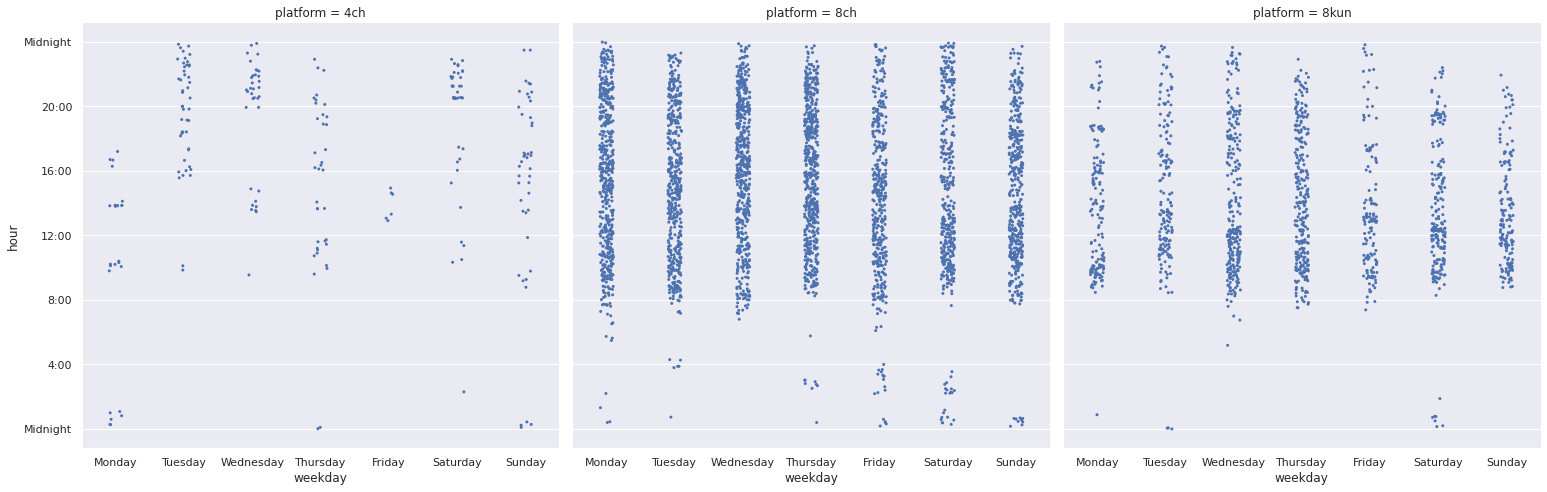

In [465]:
g = sns.FacetGrid(df, col="platform", col_wrap=4, height=7)
g.map(sns.stripplot, "weekday", "hour", size=3)

plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

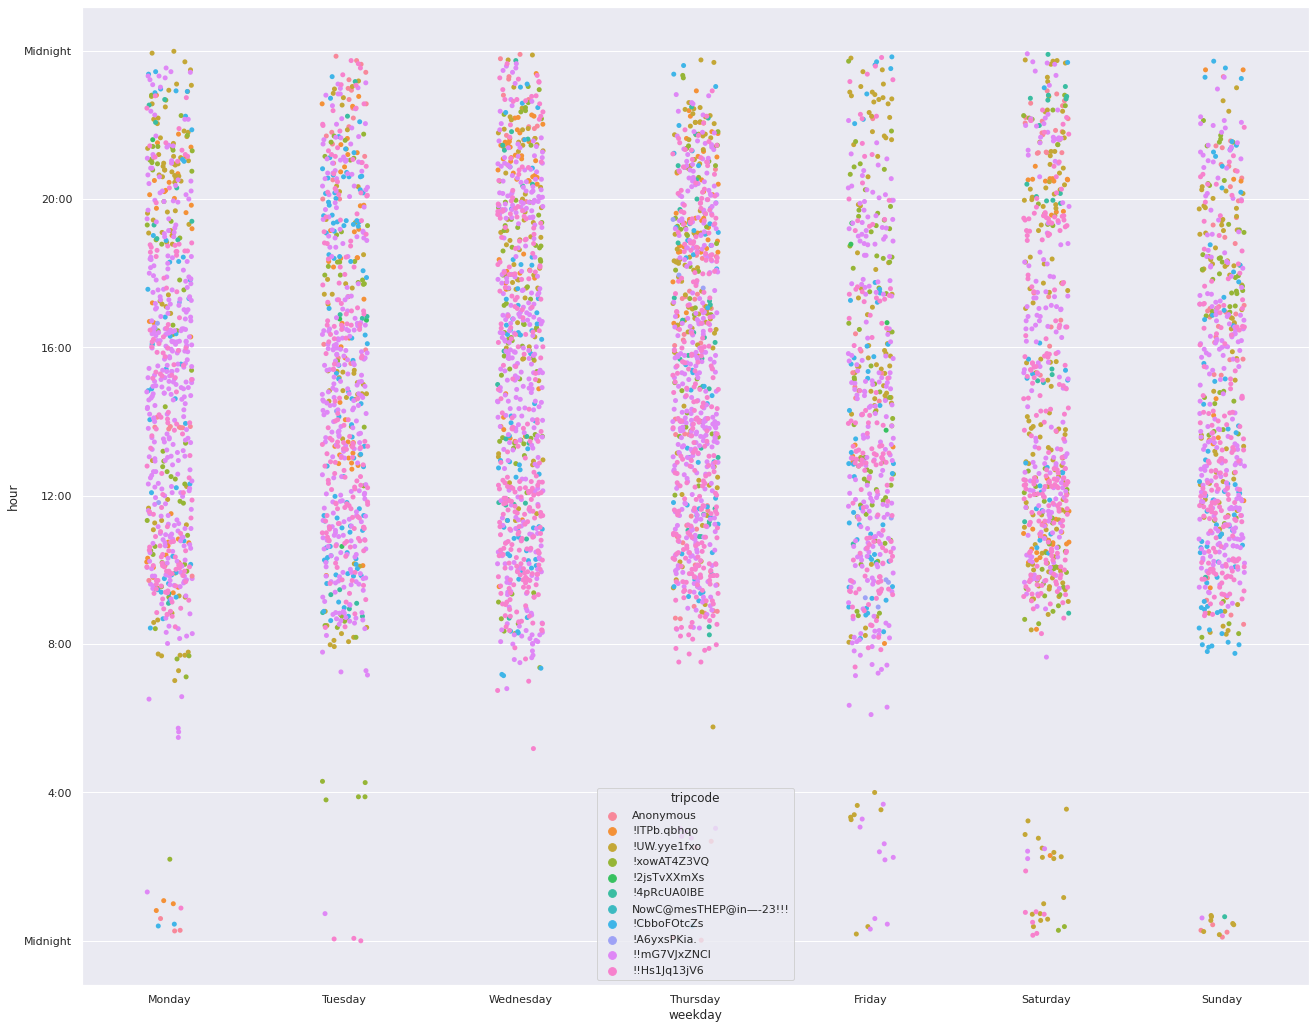

In [799]:
fig = plt.gcf()
fig.set_size_inches(22, 18)

sns.stripplot(data=df, x="weekday", y="hour", size=5, hue=df.tripcode, jitter=0.13)

plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))

<AxesSubplot:xlabel='drop_id', ylabel='Count'>

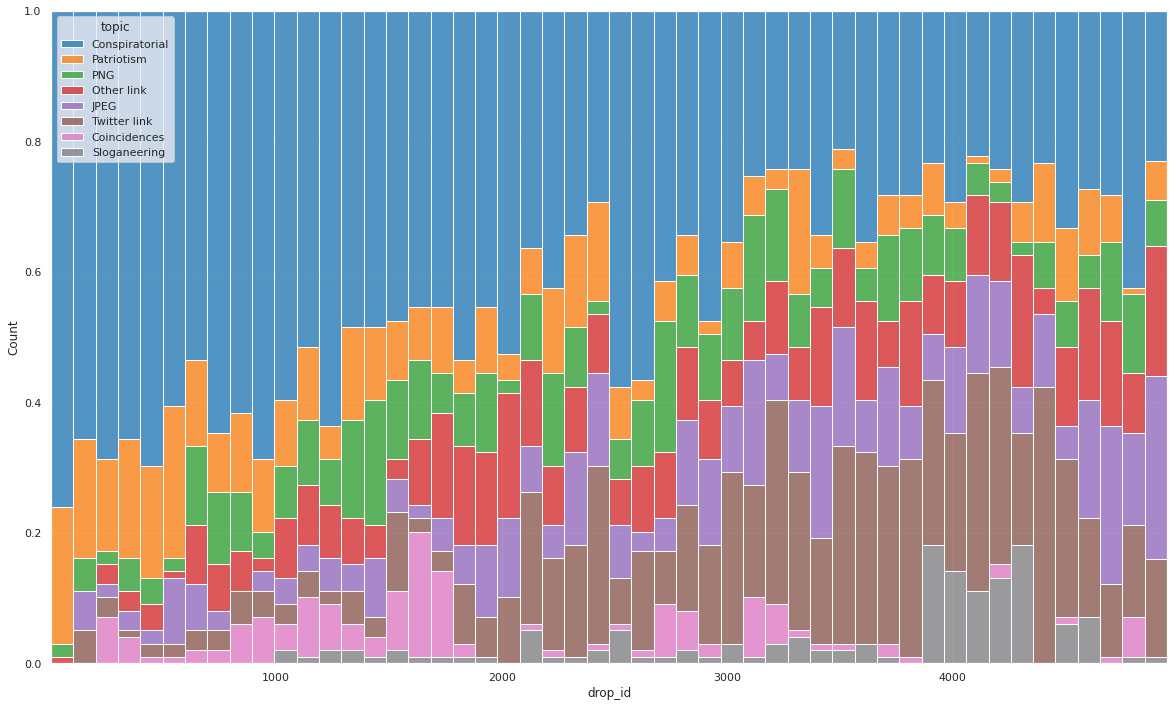

In [354]:
fig = plt.gcf()
fig.set_size_inches(20, 12)

# drops_150_to_300_c =  df.drop_id > 150
# drops_150_to_300_c &= df.drop_id < 300
# drops_150_to_300 = df[drops_150_to_300_c]

sns.histplot(data=df, x='drop_id', bins=50, hue='topic', multiple='fill')

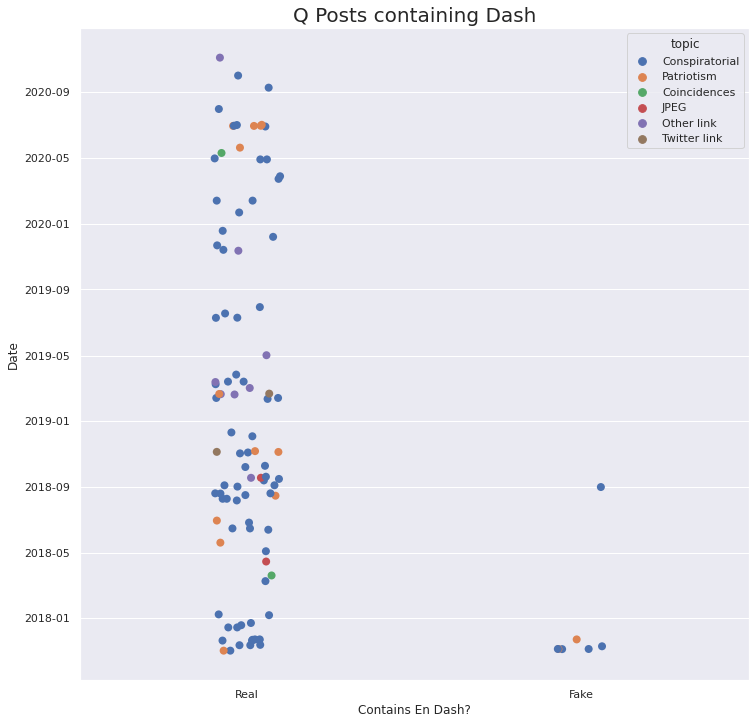

In [401]:
df['contains_en_dash'] = df.body_text.str.contains('–')
df['contains_fake_en_dash'] = df.body_text.str.contains('--')
df['contains_en_dash'] = df.contains_en_dash.replace({True: 'Real', False: 'Fake'})
fch_posts = df[df.board.str.startswith('4ch')]

contains_dash = df.body_text.str.contains('–')
contains_dash |= df.body_text.str.contains('--')

posts_containing_dash = df[contains_dash]

fig = plt.gcf()
fig.set_size_inches(12, 12)
sns.stripplot(data=posts_containing_dash, x='contains_en_dash', y='date', size=8, hue='topic', jitter=0.1)\
    .set_title('Q Posts containing Dash', size=20)
p = plt.xlabel("Contains En Dash?", size=12)
p = plt.ylabel("Date", size=12)

In [475]:
df['contains_curly_quote'] = df.body_text.str.contains('“')
df['contains_straight_quote'] = df.body_text.str.contains('"')

contains_quotes = df.contains_curly_quote
contains_quotes |= df.contains_straight_quote

df['contains_curly_quote'] = df.contains_curly_quote.replace({True: 'Curly', False: 'Straight'})

posts_containing_quotes = df[contains_quotes]

# fig = plt.gcf()
# fig.set_size_inches(12, 12)


# sns.stripplot(data=posts_containing_quotes, x='contains_curly_quote', y='date', size=8, hue='tripcode', jitter=0.1)\
#     .set_title('Q Posts containing Quotes', size=20)
# p = plt.xlabel("Quote Type", size=12)
# p = plt.ylabel("Date", size=12)

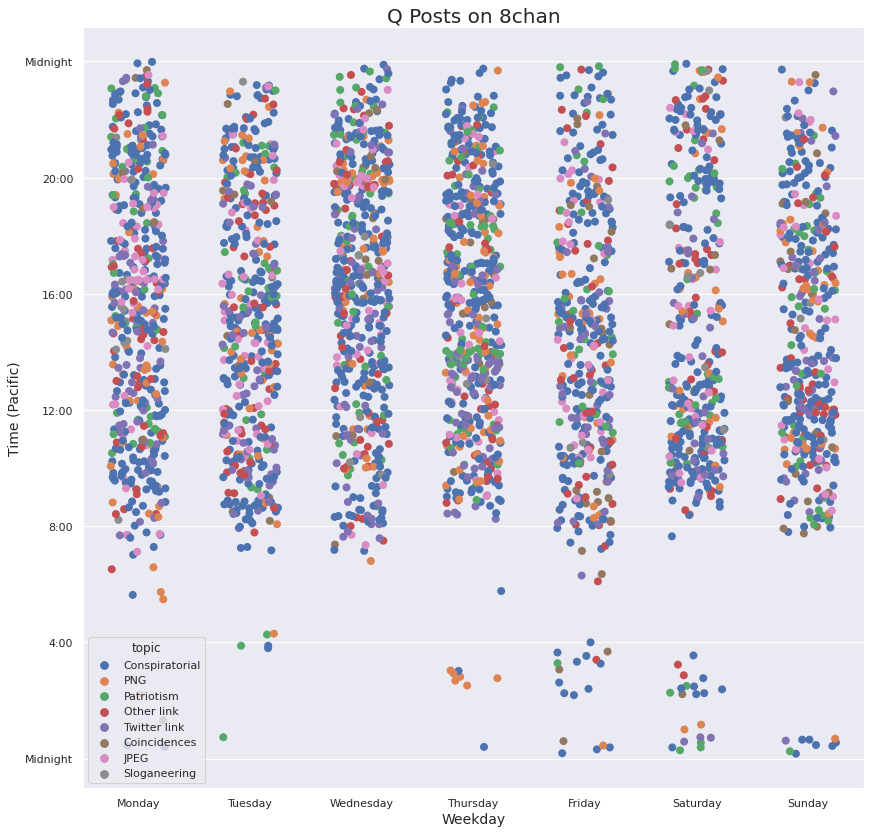

In [446]:

fig = plt.gcf()
fig.set_size_inches(14, 14)

eightch_posts = df[df.board.str.startswith('8ch')]

sns.set()
sns.stripplot(data=eightch_posts, x="weekday", y="hour", s=8, jitter=0.25, hue='topic')\
    .set_title('Q Posts on 8chan', size=20)
p = plt.xlabel("Weekday", size=14)
p = plt.ylabel("Time (Pacific)", size=14)

p = plt.yticks(np.arange(0, 25, step=4), ('Midnight', '4:00', '8:00', '12:00', '16:00', '20:00', 'Midnight'))
p = plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))

In [592]:
df['contains_special_char'] = np.where(
    df.body_text.str.contains('“')
    | df.body_text.str.contains('’')
    | df.body_text.str.contains('‘')
    | df.body_text.str.contains('…') 
    | df.body_text.str.contains('–') 
    | df.body_text.str.contains('—'), 
    'Yes', 'No')

df['contains_ordinary_punctuation'] = np.where(
    df.body_text.str.contains('--')
    | df.body_text.str.contains('"')
    | df.body_text.str.contains('\'', regex=False)
    | df.body_text.str.contains('...', regex=False), 
    'Yes', 'No')

contains_punctuation = df.contains_special_char == 'Yes'
contains_punctuation |= df.contains_ordinary_punctuation == 'Yes'

punc = df[contains_punctuation]

([<matplotlib.axis.XTick at 0x7f2df5e8fb20>,
 [Text(0, 0, 'Special'), Text(1, 0, 'Ordinary')])

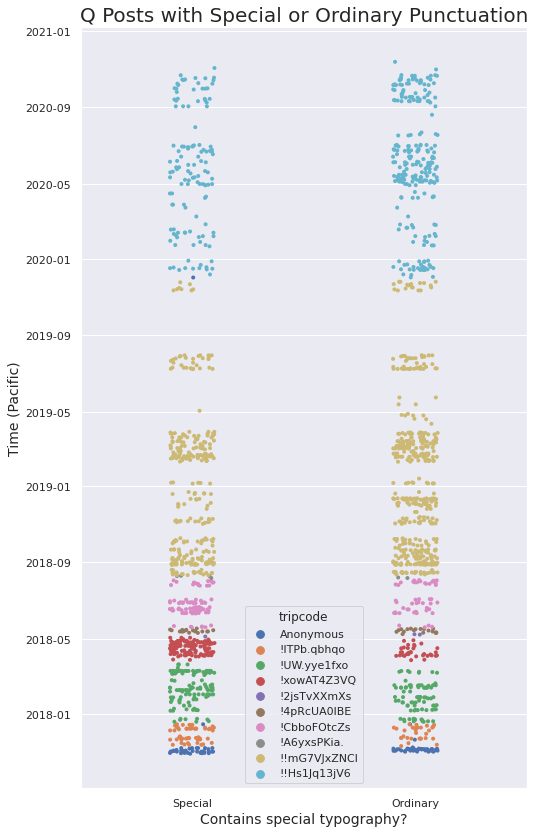

In [498]:
fig = plt.gcf()
fig.set_size_inches(8, 14)

sns.stripplot(data=punc, x="contains_special_char", y="date", size=4, hue='tripcode')\
    .set_title('Q Posts with Special or Ordinary Punctuation', size=20)
p = plt.xlabel("Contains special typography?", size=14)
p = plt.ylabel("Time (Pacific)", size=14)
plt.xticks(np.arange(2), ('Special', 'Ordinary'))


In [508]:
mixed_punc = df[df.contains_special_char == 'Yes'][df.contains_ordinary_punctuation == 'Yes'][df.is_reply == False]

print(len(mixed_punc))

178


<ipython-input-508-03a210451019>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mixed_punc = df[df.contains_special_char == 'Yes'][df.contains_ordinary_punctuation == 'Yes'][df.is_reply == False]
<ipython-input-508-03a210451019>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mixed_punc = df[df.contains_special_char == 'Yes'][df.contains_ordinary_punctuation == 'Yes'][df.is_reply == False]


In [735]:
pol = pd.read_csv('polscrape.csv', parse_dates=True)

In [736]:
pol

Unnamed: 0                                                  0
0               0                                    >she\nno. hands
1               1                >>299977779\nbuilt for Turkish cock
2               2  >>299977779\n>FREE\nwho would want transgender...
3               3                        >>299977779\nIs this a man?
4               4     >>299977779\n\nIs that shopped? What a goblin.
...           ...                                                ...
11603       11603                                             schlop
11604       11604                                  >>299992914\nTrue
11605       11605                                 >>299992914\nTRUTH
11606       11606  >>299992914\n\nEVERYONE POINT AND LAUGH AT THE...
11607       11607  >>299992914\ngay blackpilled doomer, low energ...

[11608 rows x 2 columns]

In [737]:
pol['comment'] = pol['0']
pol = pol.drop('0', axis=1)

In [749]:
pol['contains_special_char'] = np.where(
    pol.comment.str.contains('“')
    | pol.comment.str.contains('’')
    | pol.comment.str.contains('‘')
    | pol.comment.str.contains('…') 
    | pol.comment.str.contains('–') 
    | pol.comment.str.contains('—'), 
    'Yes', 'No')


In [776]:
substantial_pol = pol[pol.post_length_chars > 500]
len(substantial_pol[substantial_pol.special == 1]) / len(substantial_pol)

0.1662269129287599

In [789]:
pol.post_length_chars.mean()

122.51940588807355

In [514]:
len(pol[pol.contains_special_char == 'Yes']) / len(pol)

0.04143694004135079

In [515]:
len(df[df.contains_special_char == 'Yes']) / len(df)

0.1732633279483037

In [813]:
df.platform
tripcodes = df.tripcode.unique()
tripcodes

array(['Anonymous', '!ITPb.qbhqo', '!UW.yye1fxo', '!xowAT4Z3VQ',
       '!2jsTvXXmXs', '!4pRcUA0lBE', 'NowC@mesTHEP@in—-23!!!',
       '!CbboFOtcZs', '!A6yxsPKia.', '!!mG7VJxZNCI', '!!Hs1Jq13jV6'],
      dtype=object)

In [820]:
popular_trips = df[df.tripcode != '!2jsTvXXmXs']
popular_trips = popular_trips[popular_trips.tripcode != 'NowC@mesTHEP@in—-23!!!']
popular_trips = popular_trips[popular_trips.tripcode != '!A6yxsPKia.']
popular_trips

drop_id                       date      tripcode           board  \
0           1  2017-10-28 13:44:28-07:00     Anonymous         4ch/pol   
1           2  2017-10-28 15:15:48-07:00     Anonymous         4ch/pol   
2           3  2017-10-29 08:47:07-07:00     Anonymous         4ch/pol   
3           4  2017-10-29 09:11:40-07:00     Anonymous         4ch/pol   
4           5  2017-10-29 09:47:18-07:00     Anonymous         4ch/pol   
...       ...                        ...           ...             ...   
4947     4948  2020-11-02 14:48:50-08:00  !!Hs1Jq13jV6  8kun/qresearch   
4948     4949  2020-11-02 22:27:36-08:00  !!Hs1Jq13jV6  8kun/qresearch   
4949     4950  2020-11-12 18:32:39-08:00  !!Hs1Jq13jV6  8kun/qresearch   
4950     4951  2020-11-12 19:20:17-08:00  !!Hs1Jq13jV6  8kun/qresearch   
4951     4952  2020-11-12 21:20:55-08:00  !!Hs1Jq13jV6  8kun/qresearch   

          thread      time       hour   hour_utc  time_utc  \
0            NaN  13:44:28  13.733333  20.733333  20:44:28   
1            NaN  15:15:48  15.250000  22.250000  22:15:48   
2            NaN  08:47:07   8.783333  15.783333  15:47:07   
3            NaN  09:11:40   9.183333  16.183333  16:11:40   
4            NaN  09:47:18   9.783333  16.783333  16:47:18   
...          ...       ...        ...        ...       ...   
4947  11414108.0  14:48:50  14.800000  22.800000  22:48:50   
4948  11422223.0  22:27:36  22.450000   6.450000  06:27:36   
4949  11617856.0  18:32:39  18.533333   2.533333  02:32:39   
4950  11618946.0  19:20:17  19.333333   3.333333  03:20:17   
4951  11621106.0  21:20:55  21.333333   5.333333  05:20:55   

      minutes_since_last_drop  ...  weekday  is_uppercase           topic  \
0                         NaN  ...        5         False  Conspiratorial   
1                   91.333333  ...        5         False  Conspiratorial   
2                 1051.316667  ...        6         False      Patriotism   
3                   24.550000  ...        6         False  Conspiratorial   
4                   35.633333  ...        6         False  Conspiratorial   
...                       ...  ...      ...           ...             ...   
4947              2877.983333  ...        0         False    Twitter link   
4948               458.766667  ...        0         False      Other link   
4949             14165.050000  ...        3         False             PNG   
4950                47.633333  ...        3         False  Conspiratorial   
4951               120.633333  ...        3         False  Conspiratorial   

      is_reply                                          body_text  \
0         True   >>147005381 >>146981635 Hillary Clinton will ...   
1        False   Mockingbird HRC detained, not arrested (yet)....   
2        False   Open your eyes. It finally came out that Rod/...   
3        False   Some of us come here to drop crumbs, just cru...   
4        False   Follow the money, it’s the key. What is Pelos...   
...        ...                                                ...   
4947     False   https://twitter.com/TimMurtaugh/status/132331...   
4948     False   largest_flying_flag_in_america.jpg https://ww...   
4949     False   GodBlessAmerica.png Nothing can stop what is ...   
4950     False   Shall we play a game? [N]othing [C]an [S]top ...   
4951     False                                         Durham. Q    

      contains_special_char contains_ordinary_punctuation special source  \
0                       Yes                            No       1      Q   
1                        No                            No       0      Q   
2                       Yes                           Yes       1      Q   
3                       Yes                            No       1      Q   
4                       Yes                            No       1      Q   
...                     ...                           ...     ...    ...   
4947                     No                            No       0      Q   
4948      

<Figure size 1008x1008 with 0 Axes>

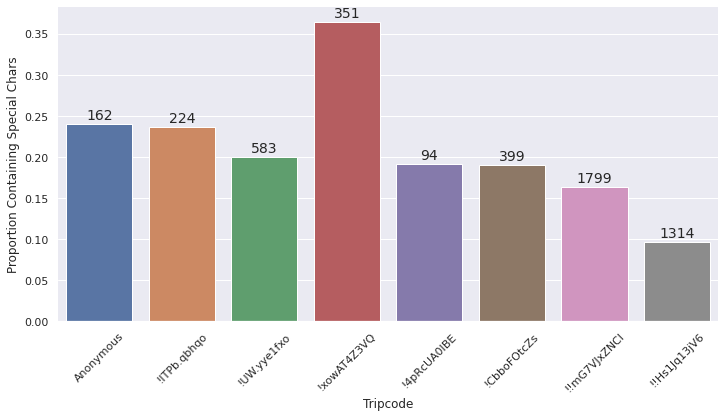

In [827]:
fig = plt.gcf()
fig.set_size_inches(14, 14)

tripcodes = popular_trips.tripcode.unique()

g = sns.catplot(x='tripcode', y='special',
    data = popular_trips, kind="bar", ci=None, aspect=2)

(g.set_axis_labels("Tripcode", "Proportion Containing Special Chars")

  .set_titles("Test")

  .despine(left=True))

plt.xticks(rotation=45)

for i, bar in enumerate(g.ax.patches):
    h = bar.get_height()
    g.ax.text(
        i, # bar index (x coordinate of text)
        h + 0.01, # y coordinate of text
        '{}'.format(len(df[df.tripcode == tripcodes[i]])),  # y label
        ha='center', 
        va='center',
        size=14)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Anonymous'),
  Text(1, 0, '!ITPb.qbhqo'),
  Text(2, 0, '!UW.yye1fxo'),
  Text(3, 0, '!xowAT4Z3VQ'),
  Text(4, 0, '!4pRcUA0lBE'),
  Text(5, 0, '!CbboFOtcZs'),
  Text(6, 0, '!!mG7VJxZNCI'),
  Text(7, 0, '!!Hs1Jq13jV6')])

<Figure size 1008x1008 with 0 Axes>

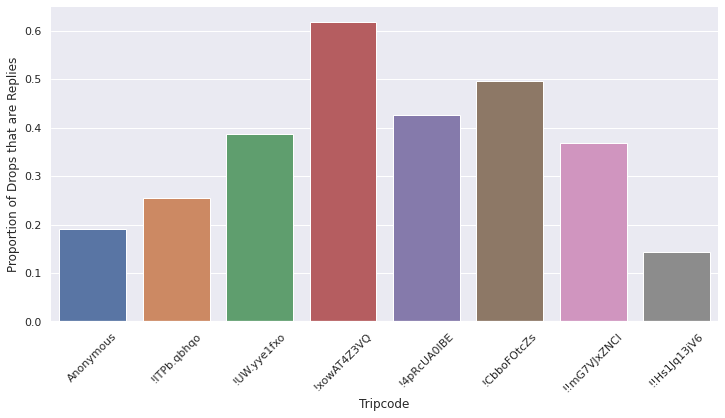

In [849]:
fig = plt.gcf()
fig.set_size_inches(14, 14)

tripcodes = popular_trips.tripcode.unique()

g = sns.catplot(x='tripcode', y='is_reply',
    data = popular_trips, kind="bar", ci=None, aspect=2)

(g.set_axis_labels("Tripcode", "Proportion of Drops that are Replies")

  .set_titles("Test")

  .despine(left=True))

plt.xticks(rotation=45)

In [770]:
df['special'] = df.contains_special_char.replace({'Yes': 1, 'No': 0})
pol['special'] = pol.contains_special_char.replace({'Yes': 1, 'No': 0})

df['source'] = 'Q'
pol['source'] = '/pol/'

In [662]:
spec = pd.concat([pol, df], axis=0)
len(spec)

16560

In [642]:
spec = spec[spec.special == 1]

In [766]:
pol['post_length_chars'] = pol.comment.str.len()

In [630]:
spec[spec.special == 1]

Unnamed: 0                                            comment  \
54          54.0      >>299977779\nIn my country she’s fine enough.   
72          72.0  Can’t even meme anymore. She’s ugly af and it ...   
225        225.0  >>299992146\nLet me guess, everyone in /ptg/ t...   
240        240.0                       >>299994670\nIt’s on bitches   
335        335.0  >>299991124\nI’m spamming this so this is what...   
...          ...                                                ...   
4885         NaN                                                NaN   
4888         NaN                                                NaN   
4895         NaN                                                NaN   
4934         NaN                                                NaN   
4948         NaN                                                NaN   

     contains_special_char  post_length_chars  special source  drop_id  \
54                     Yes               44.0        1  /pol/      NaN   
72                     Yes              117.0        1  /pol/      NaN   
225                    Yes              106.0        1  /pol/      NaN   
240                    Yes               27.0        1  /pol/      NaN   
335                    Yes               70.0        1  /pol/      NaN   
...                    ...                ...      ...    ...      ...   
4885                   Yes              377.0        1      Q   4886.0   
4888                   Yes              253.0        1      Q   4889.0   
4895                   Yes              324.0        1      Q   4896.0   
4934                   Yes              436.0        1      Q   4935.0   
4948                   Yes              328.0        1      Q   4949.0   

                           date      tripcode           board  ...  \
54                          NaN           NaN             NaN  ...   
72                          NaN           NaN             NaN  ...   
225                         NaN           NaN             NaN  ...   
240                         NaN           NaN             NaN  ...   
335                         NaN           NaN             NaN  ...   
...                         ...           ...             ...  ...   
4885  2020-10-17 12:42:05-07:00  !!Hs1Jq13jV6  8kun/qresearch  ...   
4888  2020-10-17 21:48:28-07:00  !!Hs1Jq13jV6  8kun/qresearch  ...   
4895  2020-10-18 09:45:38-07:00  !!Hs1Jq13jV6  8kun/qresearch  ...   
4934  2020-10-22 08:45:06-07:00  !!Hs1Jq13jV6  8kun/qresearch  ...   
4948  2020-11-02 22:27:36-08:00  !!Hs1Jq13jV6  8kun/qresearch  ...   

      Unnamed: 17 Unnamed: 18  Unnamed: 19  Unnamed: 20 Unnamed: 21  \
54            NaN         NaN          NaN          NaN         NaN   
72            NaN         NaN          NaN          NaN         NaN   
225           NaN         NaN          NaN          NaN         NaN   
240           NaN         NaN          NaN          NaN         NaN   
335           NaN         NaN          NaN          NaN         NaN   
...           ...         ...          ...          ...         ...   
4885          NaN         NaN          NaN          NaN         NaN   
4888          NaN         NaN          NaN          NaN         NaN   
4895          NaN         NaN          NaN          NaN         NaN   
4934          NaN         NaN          NaN          NaN         NaN   
4948          NaN         NaN          NaN          NaN         NaN   

      Unnamed: 22  Unnamed: 23  Unnamed: 24 Unnamed: 25  \
54            NaN          NaN          NaN         NaN   
72            NaN          NaN          NaN         NaN   
225           NaN          NaN          NaN         NaN   
240           NaN          NaN          NaN         NaN   
335           NaN          NaN          NaN         NaN   
...           ...          ...          ...         ...   
4885          NaN          NaN          NaN         NaN   
4888          NaN          NaN          NaN         NaN   
4895          NaN          NaN         

In [664]:
under300 = spec[spec.post_length_chars <= 300]

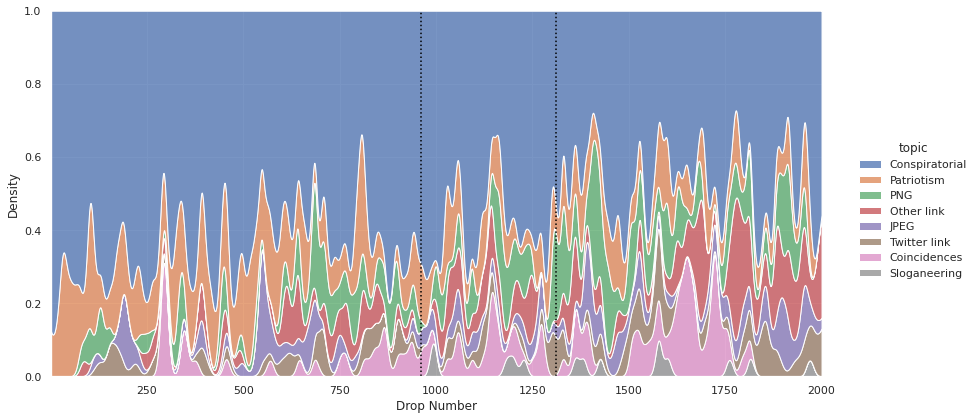

In [843]:
posts_before_2000 = df[df.drop_id <= 2000]
sns.set()
sns.displot(posts_before_2000, x='drop_id', hue='topic', cumulative=False, kind='kde', multiple='fill', height=6, aspect=2, bw_adjust=0.05, gridsize=2000, cut=0, legend=True)
plt.xlabel("Drop Number", size=12)

plt.axvline(x=962, ls=':', color='black')
plt.axvline(x=1312, ls=':', color='black')

689


<AxesSubplot:xlabel='features_x', ylabel='features_y'>

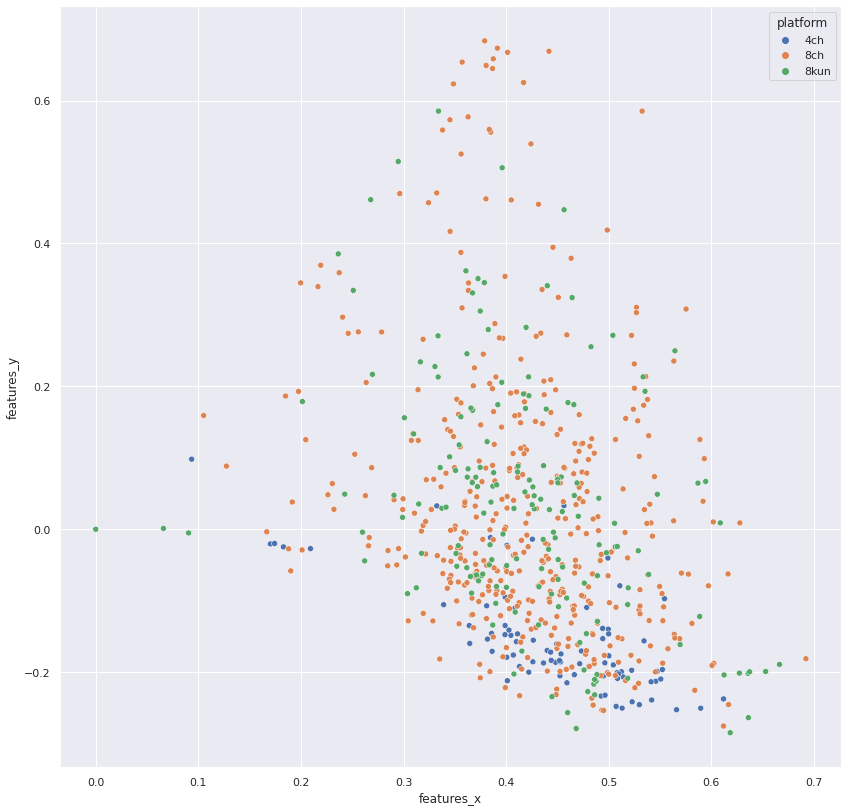

In [1065]:
import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import TruncatedSVD


features = pd.DataFrame()


def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens
 
 
def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.8,
                                 min_df=0.01,
                                 analyzer='char_wb',
                                 ngram_range=(1,3), # Let's look at trigrams
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    
    pca = TruncatedSVD(n_components=2).fit(tfidf_model)
    data2D = pca.transform(tfidf_model)
    features = pd.DataFrame(data2D, columns=['features_x', 'features_y'])
    
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering, features


# Take a subset of the drops
substantial = df[df.post_length_chars > 500]
substantial.reset_index(drop=True, inplace=True)
print(len(substantial))

# Remove duplicate columns (we're about to re-generate these)
substantial = substantial.drop(['features_x', 'features_y', 'features_cluster'], axis=1)

# Define the dataset (drop text)
articles = list(substantial.body_text)

# Get features
clusters, features = cluster_texts(articles, 4)

features['features_cluster'] = None

for cluster, index in clusters.items():
    features.at[index, 'features_cluster'] = cluster

substantial = pd.concat([substantial, features], axis=1)


# Now plot it

fig = plt.gcf()
fig.set_size_inches(14, 14)

sns.scatterplot(data=substantial, x='features_x', y='features_y', hue='platform')